# Near-Surface Air Temperature

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]


In [ ]:
# from dask.distributed import Client
# client = Client()
# client

## Set variables

In [2]:
period = slice('1979','2014')
latlim, lonlim = u.get_domain_HMA()

# Make a extended version for regridding properly on the edges
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

var = 'tas'
table = u.get_table(var)
label, units, cmap, levels = u.get_var_infos(var)
label

'Near-Surface Air Temperature'

## Load topography

In [3]:
ds = xr.open_dataset('GMTED2010_15n240_1000deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

## Load obs
cru_ts4.00: https://crudata.uea.ac.uk/cru/data/hrg/

In [4]:
obs_longname = 'CRU TS v. 4.00'
obs_name = 'CRU'

obs = xr.open_dataset('/bdd/cru/cru_ts_4.00/data/tmp/cru_ts4.00.1901.2015.tmp.dat.nc').sel(
    time=period, lat=latlim_ext, lon=lonlim_ext).tmp
obs_clim = u.clim(obs, calendar=obs.time.encoding['calendar'])
# obs_clim.plot()

## Regrid obs towards the elevation grid of 1°x1°
Using xESMF (https://xesmf.readthedocs.io/en/latest/)

In [5]:
regridder = xe.Regridder(obs_clim, elevation, 'bilinear', periodic=False, reuse_weights=True)
obs_clim_regrid = regridder(obs_clim)
obs_clim_regrid.attrs['long_name'] = 'Air Temperature'
obs_clim_regrid.attrs['units'] = units

Reuse existing file: bilinear_70x120_35x60.nc


[#Load-results](#Load-results)

## Load models

In [9]:
list_models = u.get_model_names()
# list_models = list_models[16:36]
# list_models = ['EC-Earth3']

resolution = []
bias = []
rmse = []
mb = []

for i, model in enumerate(list_models):
    print(model)
    institute, grid, realization, calendar = u.get_model_infos(model, var)
    ds = xr.open_mfdataset(
        '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*.nc', 
        combine='by_coords').sel(time=period, lat=latlim_ext, lon=lonlim_ext)[var]
    
#     # Get calendar (ds.time.encoding['calendar'] does'nt work for some models)
#     # Looks like to be for chunked datasets... bug of xarray?
#     if model in ['CESM2-FV2', 'CESM2-WACCM-FV2', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H']:
#         calendar = '365_day'
#     elif model in ['EC-Earth3', 'EC-Earth3-Veg', 'EC-Earth3-Veg-LR']:
#         calendar = 'gregorian'
#     elif model in ['GFDL-CM4']:
#         calendar = 'noleap'
#     else:
#         calendar = ds.time.encoding['calendar']
    
    # Check if the time steps are ok
    np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, ds.time.size)
    
    # Compute climatology
    model_clim = u.clim(ds, calendar=calendar) - 273.15
    
    # Print resolution
    lat = (model_clim.lat[1] - model_clim.lat[0]).values
    lon = (model_clim.lon[1] - model_clim.lon[0]).values
    print(
        'lat = '+str(lat.round(2))+' / '+
        'lon = '+str(lon.round(2))
    )
    resolution.append(str(lat.round(1))+'°x'+str(lon.round(1))+'°')

    # Regrid towards elevation grid 1°x1°
    regridder = xe.Regridder(model_clim, elevation, 'bilinear', periodic=False, reuse_weights=True)
    model_clim_regrid = regridder(model_clim)
    
    # Compute the bias
    bias.append((model_clim_regrid - obs_clim_regrid).sel(lat=latlim, lon=lonlim).load())
    
    # Compute the pattern/spatial area-weighted RMSE and mean bias
    rmse.append(np.sqrt(u.spatial_average(bias[i].where(elevation > 2500)**2)))
    mb.append(u.spatial_average(bias[i].where(elevation > 2500)))

BCC-CSM2-MR
lat = 1.12 / lon = 1.12
Reuse existing file: bilinear_32x54_35x60.nc
BCC-ESM1
lat = 2.79 / lon = 2.81
Reuse existing file: bilinear_13x21_35x60.nc
CAS-ESM2-0
lat = 1.42 / lon = 1.41
Reuse existing file: bilinear_24x42_35x60.nc
CESM2


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/conventions.py:487: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


lat = 0.94 / lon = 1.25
Reuse existing file: bilinear_37x49_35x60.nc
CESM2-FV2


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/conventions.py:487: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


lat = 1.89 / lon = 2.5
Reuse existing file: bilinear_18x25_35x60.nc
CESM2-WACCM


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/conventions.py:487: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


lat = 0.94 / lon = 1.25
Reuse existing file: bilinear_37x49_35x60.nc
CESM2-WACCM-FV2


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/conventions.py:487: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


lat = 1.89 / lon = 2.5
Reuse existing file: bilinear_18x25_35x60.nc
CIESM
lat = 0.94 / lon = 1.25
Reuse existing file: bilinear_37x49_35x60.nc
CNRM-CM6-1
lat = 1.4 / lon = 1.41
Reuse existing file: bilinear_25x42_35x60.nc
CNRM-CM6-1-HR
lat = 0.5 / lon = 0.5
Reuse existing file: bilinear_70x121_35x60.nc
CNRM-ESM2-1
lat = 1.4 / lon = 1.41
Reuse existing file: bilinear_25x42_35x60.nc
CanESM5
lat = 2.79 / lon = 2.81
Reuse existing file: bilinear_13x21_35x60.nc
CanESM5-CanOE
lat = 2.79 / lon = 2.81
Reuse existing file: bilinear_13x21_35x60.nc
EC-Earth3
lat = 0.7 / lon = 0.7
Reuse existing file: bilinear_50x85_35x60.nc
EC-Earth3-Veg
lat = 0.7 / lon = 0.7
Reuse existing file: bilinear_50x85_35x60.nc
FGOALS-f3-L
lat = 1.0 / lon = 1.25
Reuse existing file: bilinear_35x48_35x60.nc
GFDL-CM4
lat = 1.0 / lon = 1.25
Reuse existing file: bilinear_35x48_35x60.nc
GISS-E2-1-G
lat = 2.0 / lon = 2.5
Reuse existing file: bilinear_18x24_35x60.nc
GISS-E2-1-G-CC
lat = 2.0 / lon = 2.5
Reuse existing file: bili

## Make multi-model ensemble and average

In [31]:
# Concatenate the multimodel ensemble
multimodel_ensemble = xr.concat(
    bias, pd.Index(list_models, name="realization"), coords='minimal', compat='override'
)

# Add multimodel mean
mmm = multimodel_ensemble.mean('realization')

resolution_mmm = resolution.copy()
resolution_mmm.append('1°x1°')

bias_mmm = bias.copy()
bias_mmm.append(mmm)

list_models_mmm = list_models.copy()
list_models_mmm.append('multi-model mean')

rmse_mmm = rmse.copy()
rmse_mmm.append(np.sqrt(u.spatial_average(mmm.where(elevation > 2500)**2)))

mb_mmm = mb.copy()
mb_mmm.append(u.spatial_average(mmm.where(elevation > 2500)))

# Concatenate the mmm of the multimodel_ensemble
multimodel_ensemble_mmm = xr.concat(
    bias_mmm, pd.Index(list_models_mmm, name="model"), coords='minimal', compat='override'
)

# Add the rmse and mb as coordinates
multimodel_ensemble_mmm = multimodel_ensemble_mmm.assign_coords({
    'rmse': ('model', rmse_mmm),
    'mean_bias': ('model', mb_mmm),
    'resolution': ('model', resolution_mmm),
})

## Save results

In [27]:
multimodel_ensemble_mmm.to_netcdf(
    'results/'+var+'_'+period.start+'-'+period.stop+'_multimodel_ensemble_mmm.nc'
)

## Load results

In [28]:
multimodel_ensemble_mmm = xr.open_dataarray(
    'results/'+var+'_'+period.start+'-'+period.stop+'_multimodel_ensemble_mmm.nc'
)
# multimodel_ensemble_mmm

## Check min and max

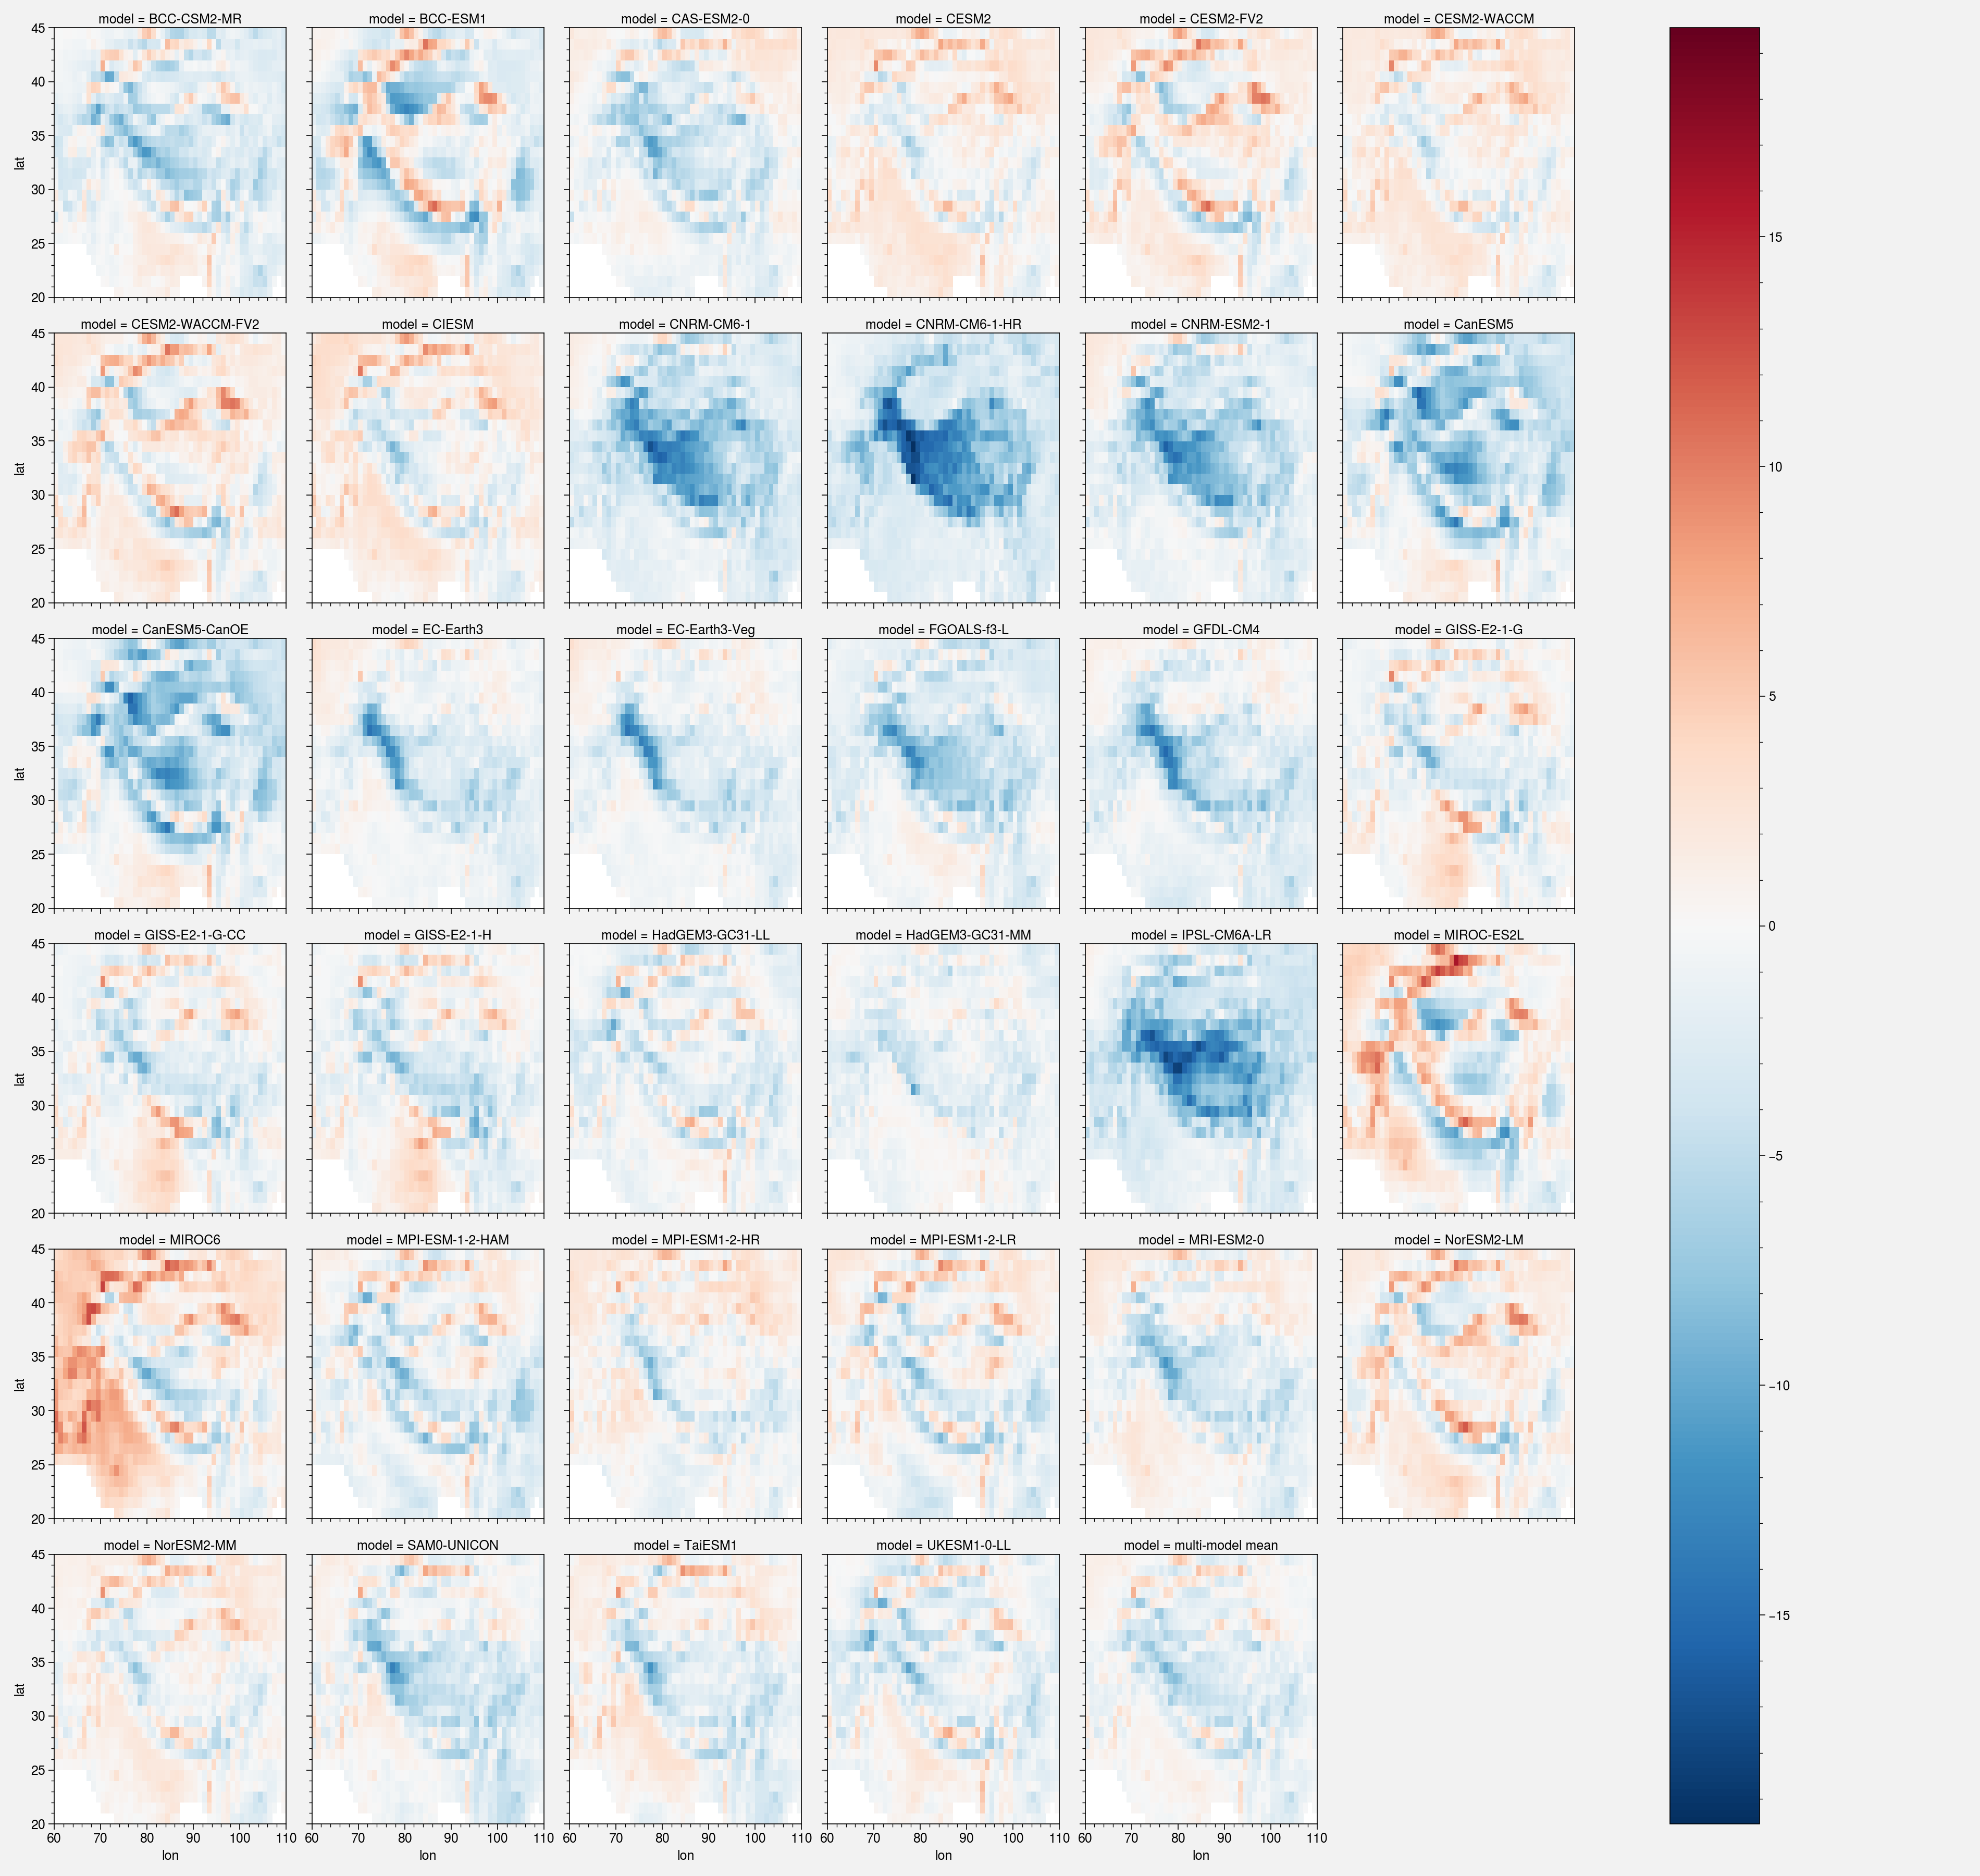

In [34]:
multimodel_ensemble_mmm.plot(col='model', col_wrap=6)

In [29]:
multimodel_ensemble_mmm.max().values, multimodel_ensemble_mmm.min().values

(array(16.07515668), array(-19.54830553))

## Make final plot

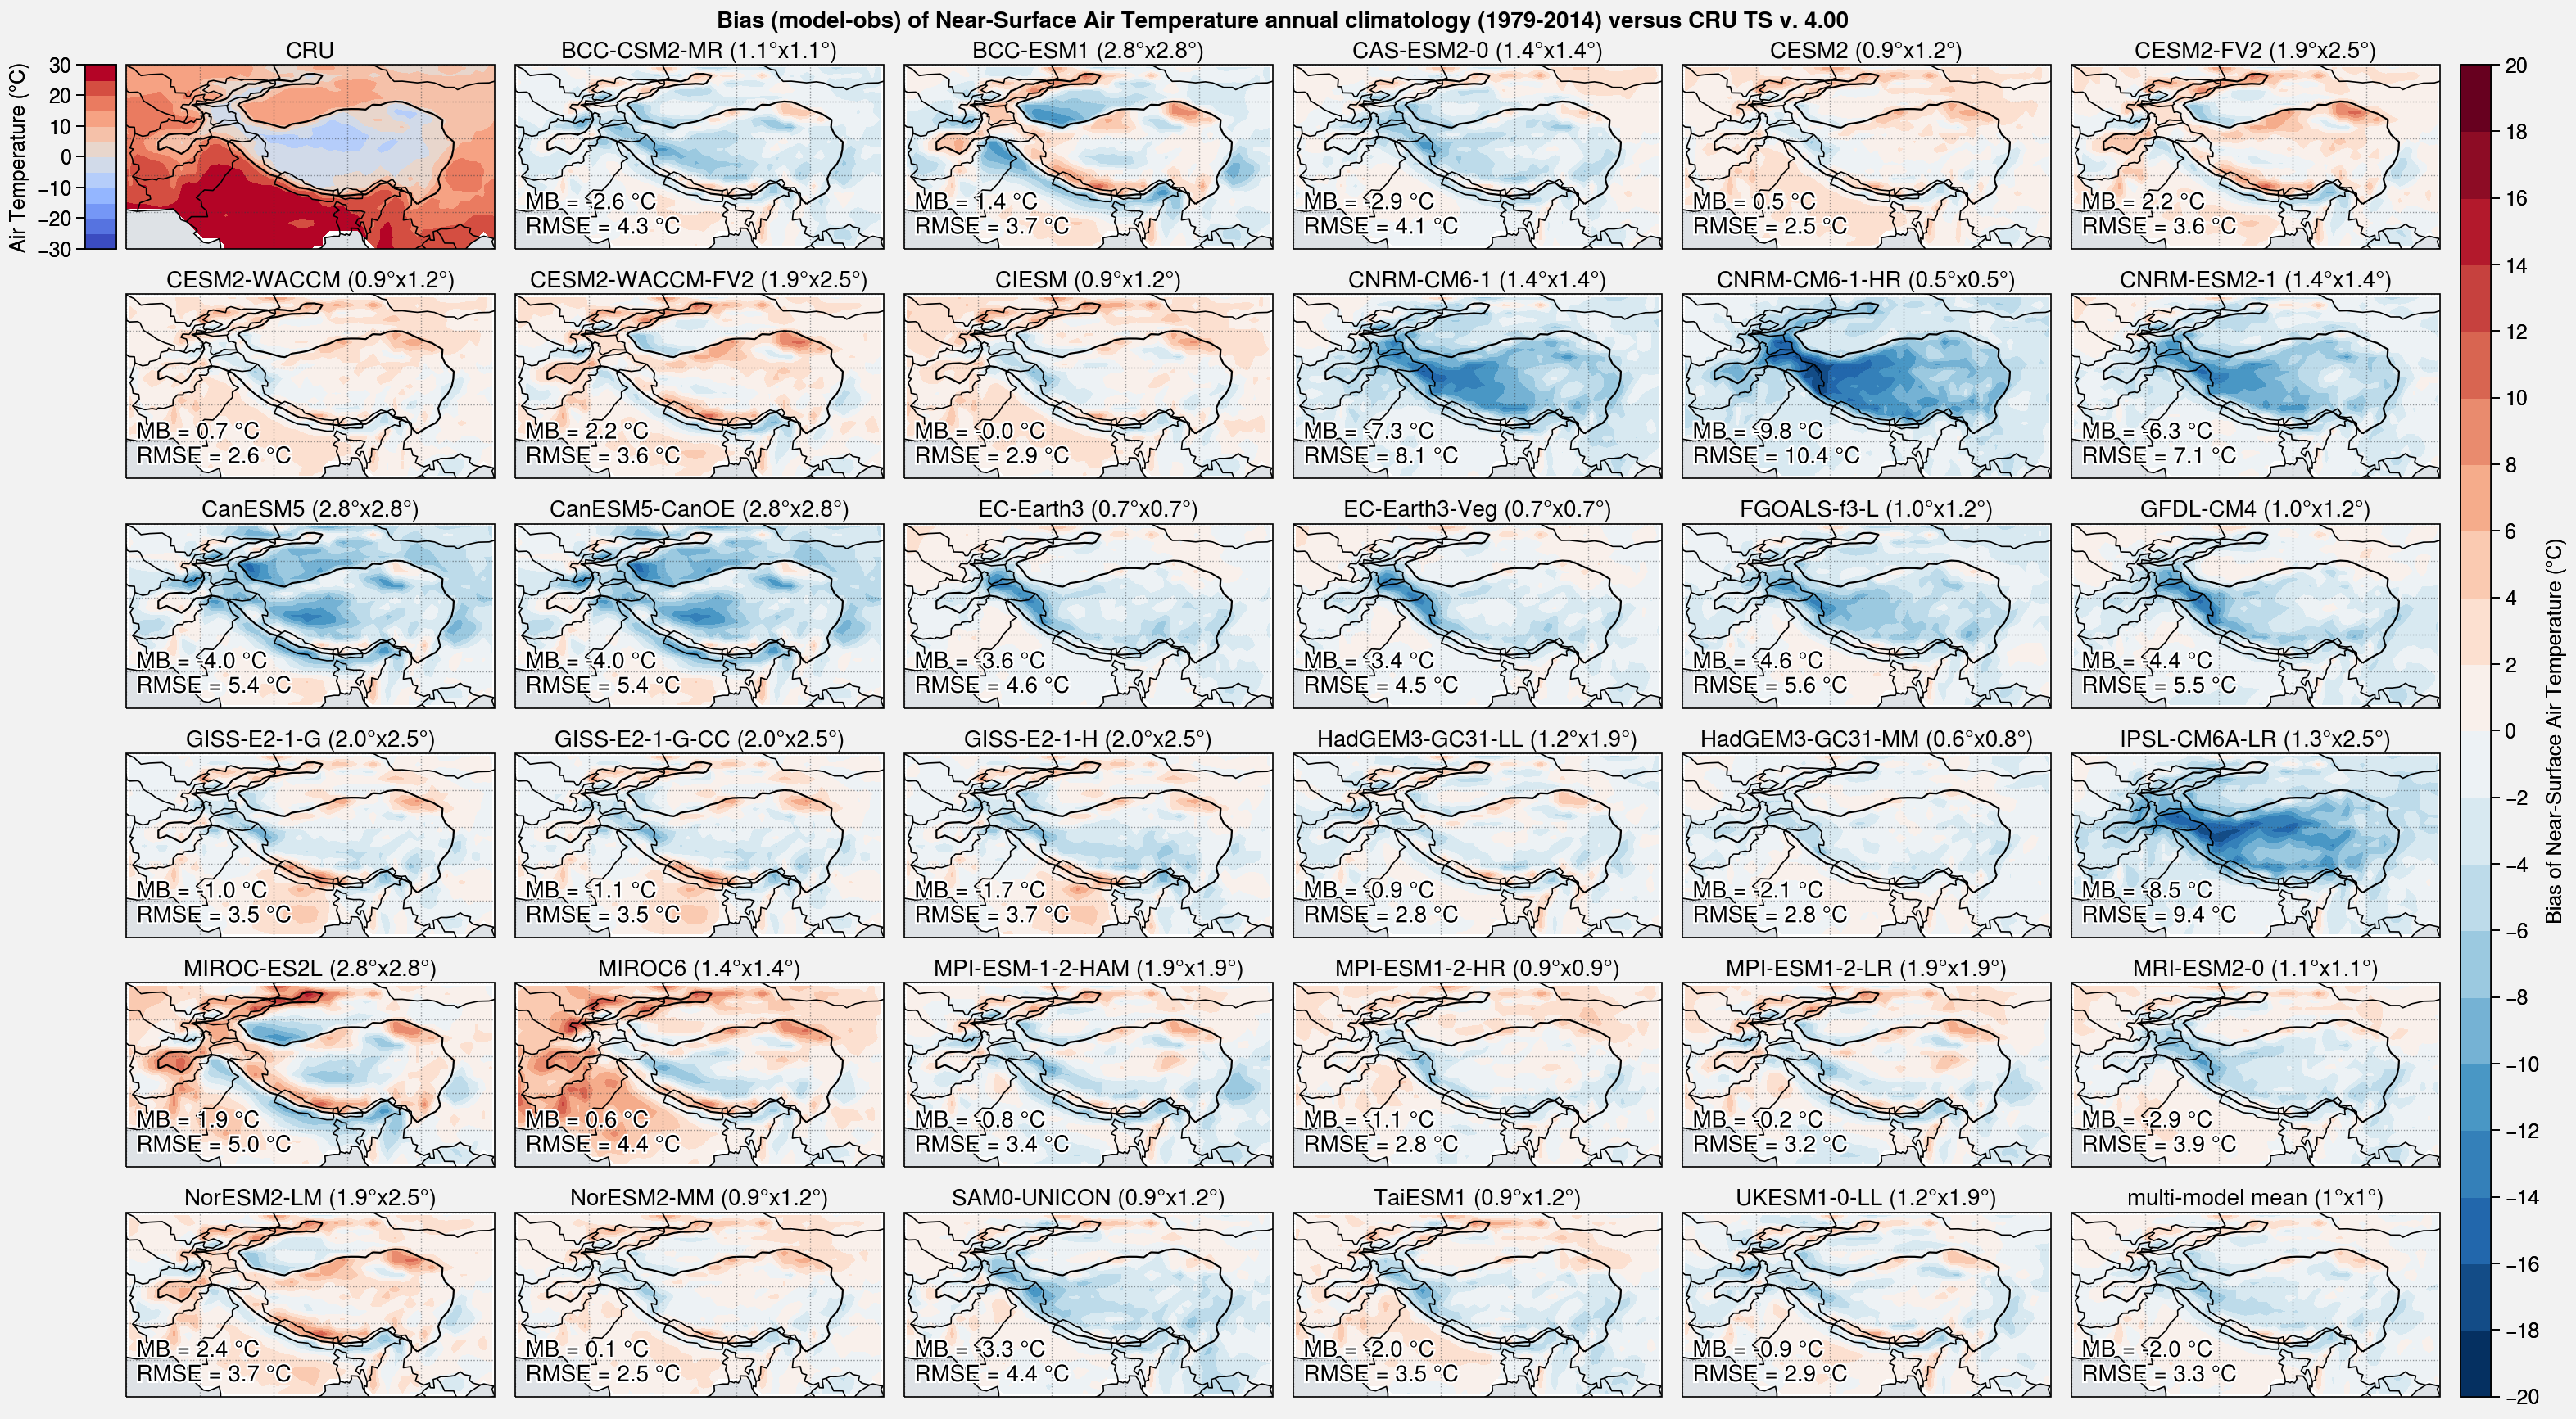

In [59]:
f, axs = plot.subplots(proj='cyl', ncols=6, nrows=6)

for i, ax in enumerate(axs):
    # Add contour 2500 m
    ax.contour(elevation, levels=[2500], color='black', linewidth=0.8)
    
    # Plot observation
    if i == 0:
        ax.contourf(obs_clim_regrid, cmap=cmap, levels=levels, colorbar='l')
        ax.format(title=obs_name)
    
    # Plot model bias
    else:
        #Plot
        m = ax.contourf(multimodel_ensemble_mmm[i-1], cmap='RdBu_r', levels=plot.arange(-20,20,2))
        ax.format(
            title=str(multimodel_ensemble_mmm.model[i-1].values)+' ('+str(multimodel_ensemble_mmm.resolution[i-1].values)+')', 
            lltitle='MB = '+str(multimodel_ensemble_mmm.mean_bias[i-1].round(1).values) +' °C\n'
                   +'RMSE = '+str(multimodel_ensemble_mmm.rmse[i-1].round(1).values) +' °C'
        )
    
f.colorbar(m, label='Bias of '+label+' ('+units+')', loc='r')

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=False, 
    coast=True, ocean=True, oceancolor='gray3', borders=True, abc=False,
    suptitle='Bias (model-obs) of '+label+' annual climatology ('+period.start+'-'+period.stop+') versus '+obs_longname,
    lonlines=10, latlines=5, latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop)
)

f.save('img/'+var+'_'+period.start+'-'+period.stop+'_bias_multimodel.jpg')
f.save('img/'+var+'_'+period.start+'-'+period.stop+'_bias_multimodel.png')
f.save('img/'+var+'_'+period.start+'-'+period.stop+'_bias_multimodel.pdf')